<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/Compress_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Compression Pipelines

 I built the individual tools, quantisation reduces precision, pruning removes weights, distillation transfers knowledge, low-rank factorization exploits structure. I combine them here. The key insight: these techniques are largely orthogonal and their benefits multiply. A model that's 4× smaller from pruning, 4× smaller from quantization, and 2× smaller from low-rank achieves 32× total compression. But order matters. Prune-then-quantize differs from quantize-then-prune. Distillation can guide any compression step. I implement systematic pipeline abstractions, compare orderings experimentally, and build toward production-ready compression workflows. This connects directly to my CompressML vision: a unified platform offering optimized compression pipelines for different deployment targets.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List, Dict, Tuple, Callable, Union
from dataclasses import dataclass, field
from enum import Enum
from abc import ABC, abstractmethod
from copy import deepcopy
from collections import OrderedDict
import math
import time
import warnings
warnings.filterwarnings('ignore')

Pipeline Abstractions

In [2]:
@dataclass
class CompressionConfig:
    """Configuration for compression pipeline."""
    # Quantization
    quantize: bool = False
    quant_bits: int = 8
    quant_symmetric: bool = True

    # Pruning
    prune: bool = False
    prune_sparsity: float = 0.5
    prune_structured: bool = False

    # Distillation
    distill: bool = False
    distill_temperature: float = 4.0
    distill_alpha: float = 0.5

    # Low-rank
    low_rank: bool = False
    rank_ratio: float = 0.5

    # Training
    finetune_epochs: int = 3
    finetune_lr: float = 0.001


@dataclass
class CompressionResult:
    """Result of compression pipeline."""
    model: nn.Module
    original_params: int
    compressed_params: int
    original_size_mb: float
    compressed_size_mb: float
    original_accuracy: float
    compressed_accuracy: float
    compression_ratio: float
    speedup_estimate: float
    steps_applied: List[str] = field(default_factory=list)
    step_metrics: Dict[str, Dict] = field(default_factory=dict)

    def summary(self) -> str:
        lines = [
            "=" * 60,
            "COMPRESSION RESULTS",
            "=" * 60,
            f"Steps: {' → '.join(self.steps_applied)}",
            f"Parameters: {self.original_params:,} → {self.compressed_params:,}",
            f"Size: {self.original_size_mb:.2f} MB → {self.compressed_size_mb:.2f} MB",
            f"Compression: {self.compression_ratio:.1f}×",
            f"Accuracy: {100*self.original_accuracy:.2f}% → {100*self.compressed_accuracy:.2f}%",
            f"Accuracy drop: {100*(self.original_accuracy - self.compressed_accuracy):.2f}%",
            f"Estimated speedup: {self.speedup_estimate:.1f}×",
            "=" * 60
        ]
        return "\n".join(lines)

In [3]:
class CompressionStep(ABC):
    """Abstract base for compression steps."""

    @property
    @abstractmethod
    def name(self) -> str:
        pass

    @abstractmethod
    def apply(self, model: nn.Module, **kwargs) -> Tuple[nn.Module, Dict]:
        """Apply compression step. Returns (compressed_model, metrics)."""
        pass


class QuantizationStep(CompressionStep):
    """Quantization compression step."""

    def __init__(self, bits: int = 8, symmetric: bool = True):
        self.bits = bits
        self.symmetric = symmetric

    @property
    def name(self) -> str:
        return f"Quantize-{self.bits}bit"

    def apply(self, model: nn.Module, **kwargs) -> Tuple[nn.Module, Dict]:
        model = deepcopy(model)

        q_min = -(2 ** (self.bits - 1)) + 1 if self.symmetric else 0
        q_max = (2 ** (self.bits - 1)) - 1 if self.symmetric else (2 ** self.bits) - 1

        total_params = 0
        quantized_params = 0

        for name, module in model.named_modules():
            if isinstance(module, nn.Linear):
                w = module.weight.data
                total_params += w.numel()

                if self.symmetric:
                    scale = w.abs().max() / q_max
                else:
                    scale = (w.max() - w.min()) / (q_max - q_min)
                scale = max(scale.item(), 1e-8)

                w_q = torch.round(w / scale).clamp(q_min, q_max) * scale
                module.weight.data = w_q
                quantized_params += w.numel()

        metrics = {
            'bits': self.bits,
            'params_quantized': quantized_params,
            'size_reduction': 32 / self.bits
        }

        return model, metrics


class PruningStep(CompressionStep):
    """Pruning compression step."""

    def __init__(self, sparsity: float = 0.5, structured: bool = False):
        self.sparsity = sparsity
        self.structured = structured

    @property
    def name(self) -> str:
        kind = "Structured" if self.structured else "Unstructured"
        return f"Prune-{kind}-{int(100*self.sparsity)}%"

    def apply(self, model: nn.Module, **kwargs) -> Tuple[nn.Module, Dict]:
        model = deepcopy(model)

        if self.structured:
            return self._structured_prune(model)
        else:
            return self._unstructured_prune(model)

    def _unstructured_prune(self, model: nn.Module) -> Tuple[nn.Module, Dict]:
        all_weights = []
        for module in model.modules():
            if isinstance(module, nn.Linear):
                all_weights.append(module.weight.data.abs().flatten())

        all_weights = torch.cat(all_weights)
        k = int(len(all_weights) * self.sparsity)
        threshold = torch.kthvalue(all_weights, k)[0]

        total_pruned = 0
        total_params = 0

        for module in model.modules():
            if isinstance(module, nn.Linear):
                mask = module.weight.data.abs() >= threshold
                module.weight.data *= mask.float()
                total_pruned += (~mask).sum().item()
                total_params += mask.numel()

        metrics = {
            'target_sparsity': self.sparsity,
            'actual_sparsity': total_pruned / total_params,
            'params_pruned': total_pruned
        }

        return model, metrics

    def _structured_prune(self, model: nn.Module) -> Tuple[nn.Module, Dict]:
        # Prune entire neurons based on L2 norm
        total_pruned = 0
        total_neurons = 0

        for module in model.modules():
            if isinstance(module, nn.Linear):
                # Compute neuron importance (L2 norm of output weights)
                importance = module.weight.data.norm(dim=1)
                k = int(len(importance) * self.sparsity)
                if k > 0:
                    threshold = torch.kthvalue(importance, k)[0]
                    mask = importance >= threshold
                    module.weight.data[~mask] = 0
                    if module.bias is not None:
                        module.bias.data[~mask] = 0
                    total_pruned += (~mask).sum().item()
                total_neurons += len(importance)

        metrics = {
            'target_sparsity': self.sparsity,
            'neurons_pruned': total_pruned,
            'total_neurons': total_neurons
        }

        return model, metrics


class LowRankStep(CompressionStep):
    """Low-rank factorization step."""

    def __init__(self, rank_ratio: float = 0.5, min_rank: int = 4):
        self.rank_ratio = rank_ratio
        self.min_rank = min_rank

    @property
    def name(self) -> str:
        return f"LowRank-{int(100*self.rank_ratio)}%"

    def apply(self, model: nn.Module, **kwargs) -> Tuple[nn.Module, Dict]:
        model = deepcopy(model)

        total_original = 0
        total_compressed = 0
        layers_factorized = 0

        for name, module in list(model.named_modules()):
            if isinstance(module, nn.Linear):
                W = module.weight.data
                m, n = W.shape
                full_rank = min(m, n)
                target_rank = max(self.min_rank, int(full_rank * self.rank_ratio))

                # SVD approximation
                U, S, Vh = torch.linalg.svd(W.float(), full_matrices=False)
                r = min(target_rank, len(S))

                # Reconstruct with reduced rank
                W_approx = (U[:, :r] * S[:r]) @ Vh[:r, :]
                module.weight.data = W_approx.to(W.dtype)

                total_original += m * n
                total_compressed += r * (m + n)
                layers_factorized += 1

        metrics = {
            'rank_ratio': self.rank_ratio,
            'layers_factorized': layers_factorized,
            'param_reduction': total_original / total_compressed if total_compressed > 0 else 1
        }

        return model, metrics

In [4]:
class DistillationStep(CompressionStep):
    """Knowledge distillation step."""

    def __init__(self, teacher: nn.Module, temperature: float = 4.0,
                 alpha: float = 0.5, epochs: int = 5, lr: float = 0.001):
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha
        self.epochs = epochs
        self.lr = lr

    @property
    def name(self) -> str:
        return f"Distill-T{self.temperature}"

    def apply(self, model: nn.Module, train_loader: DataLoader = None,
              **kwargs) -> Tuple[nn.Module, Dict]:
        if train_loader is None:
            raise ValueError("Distillation requires train_loader")

        model = deepcopy(model)
        self.teacher.eval()

        optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)

        total_loss = 0
        num_batches = 0

        for epoch in range(self.epochs):
            model.train()
            epoch_loss = 0

            for data, target in train_loader:
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()

                # Student output
                student_logits = model(data)

                # Teacher output (no grad)
                with torch.no_grad():
                    teacher_logits = self.teacher(data)

                # Hard loss
                hard_loss = F.cross_entropy(student_logits, target)

                # Soft loss
                T = self.temperature
                soft_student = F.log_softmax(student_logits / T, dim=1)
                soft_teacher = F.softmax(teacher_logits / T, dim=1)
                soft_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (T * T)

                # Combined loss
                loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                num_batches += 1

            total_loss = epoch_loss

        metrics = {
            'temperature': self.temperature,
            'alpha': self.alpha,
            'epochs': self.epochs,
            'final_loss': total_loss / len(train_loader)
        }

        return model, metrics


class FinetuneStep(CompressionStep):
    """Fine-tuning step to recover accuracy."""

    def __init__(self, epochs: int = 3, lr: float = 0.001):
        self.epochs = epochs
        self.lr = lr

    @property
    def name(self) -> str:
        return f"Finetune-{self.epochs}ep"

    def apply(self, model: nn.Module, train_loader: DataLoader = None,
              **kwargs) -> Tuple[nn.Module, Dict]:
        if train_loader is None:
            raise ValueError("Finetuning requires train_loader")

        model = deepcopy(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)

        initial_loss = None
        final_loss = None

        for epoch in range(self.epochs):
            model.train()
            epoch_loss = 0

            for data, target in train_loader:
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()
                output = model(data)
                loss = F.cross_entropy(output, target)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)
            if initial_loss is None:
                initial_loss = avg_loss
            final_loss = avg_loss

        metrics = {
            'epochs': self.epochs,
            'initial_loss': initial_loss,
            'final_loss': final_loss,
            'loss_reduction': (initial_loss - final_loss) / initial_loss if initial_loss else 0
        }

        return model, metrics

In [5]:
class CompressionPipeline:
    """Unified compression pipeline."""

    def __init__(self, steps: List[CompressionStep]):
        self.steps = steps

    def run(self, model: nn.Module, train_loader: DataLoader,
            test_loader: DataLoader, verbose: bool = True) -> CompressionResult:
        """
        Run compression pipeline.

        Args:
            model: Model to compress
            train_loader: Training data (for fine-tuning/distillation)
            test_loader: Test data (for evaluation)
            verbose: Print progress

        Returns:
            CompressionResult with metrics
        """
        # Original metrics
        original_params = sum(p.numel() for p in model.parameters())
        original_size = original_params * 4 / (1024 * 1024)  # FP32 in MB
        original_acc = self._evaluate(model, test_loader)

        if verbose:
            print(f"Original: {original_params:,} params, {100*original_acc:.2f}% acc")

        # Apply steps
        current_model = deepcopy(model)
        steps_applied = []
        step_metrics = {}

        for step in self.steps:
            if verbose:
                print(f"\nApplying: {step.name}")

            current_model, metrics = step.apply(
                current_model,
                train_loader=train_loader
            )
            current_model = current_model.to(device)

            acc = self._evaluate(current_model, test_loader)
            metrics['accuracy_after'] = acc

            steps_applied.append(step.name)
            step_metrics[step.name] = metrics

            if verbose:
                print(f"  → Accuracy: {100*acc:.2f}%")

        # Final metrics
        compressed_params = self._count_nonzero_params(current_model)
        compression_ratio = original_params / compressed_params if compressed_params > 0 else 1

        # Estimate size based on quantization
        bits = 32
        for step in self.steps:
            if isinstance(step, QuantizationStep):
                bits = step.bits
                break
        compressed_size = compressed_params * bits / 8 / (1024 * 1024)

        # Estimate speedup (rough)
        speedup = compression_ratio * (32 / bits)

        final_acc = self._evaluate(current_model, test_loader)

        return CompressionResult(
            model=current_model,
            original_params=original_params,
            compressed_params=compressed_params,
            original_size_mb=original_size,
            compressed_size_mb=compressed_size,
            original_accuracy=original_acc,
            compressed_accuracy=final_acc,
            compression_ratio=compression_ratio,
            speedup_estimate=speedup,
            steps_applied=steps_applied,
            step_metrics=step_metrics
        )

    def _evaluate(self, model: nn.Module, test_loader: DataLoader) -> float:
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                correct += model(data).argmax(1).eq(target).sum().item()
                total += data.size(0)
        return correct / total

    def _count_nonzero_params(self, model: nn.Module) -> int:
        total = 0
        for p in model.parameters():
            total += (p != 0).sum().item()
        return total

Quantization + Pruning

In [6]:
# Setup data and baseline model

class TestMLP(nn.Module):
    def __init__(self, hidden_dims: List[int] = [512, 256, 128]):
        super().__init__()
        layers = []
        prev_dim = 784
        for i, dim in enumerate(hidden_dims):
            layers.append((f'fc{i+1}', nn.Linear(prev_dim, dim)))
            layers.append((f'relu{i+1}', nn.ReLU()))
            prev_dim = dim
        layers.append(('fc_out', nn.Linear(prev_dim, 10)))
        self.layers = nn.Sequential(OrderedDict(layers))
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.layers(x.view(x.size(0), -1))


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 456kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.72MB/s]

Train: 60000, Test: 10000


In [8]:
# Train baseline
print("=" * 70)
print("TRAINING BASELINE")
print("=" * 70)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline = TestMLP().to(device)
optimizer = torch.optim.Adam(baseline.parameters(), lr=0.001)

for epoch in range(5):
    baseline.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        F.cross_entropy(baseline(data), target).backward()
        optimizer.step()

    baseline.eval()
    correct = sum(baseline(d.to(device)).argmax(1).eq(t.to(device)).sum().item()
                  for d, t in test_loader)
    print(f"Epoch {epoch+1}: {100*correct/len(test_dataset):.2f}%")

baseline_state = deepcopy(baseline.state_dict())

TRAINING BASELINE
Epoch 1: 96.92%
Epoch 2: 96.97%
Epoch 3: 97.45%
Epoch 4: 97.38%
Epoch 5: 97.54%


In [9]:
# Experiment 1: Prune then Quantize vs Quantize then Prune

print("\n" + "=" * 70)
print("EXPERIMENT 1: Pruning + Quantization Order")
print("=" * 70)

# Pipeline 1: Prune → Finetune → Quantize
print("\n[Pipeline 1: Prune → Finetune → Quantize]")
model1 = TestMLP().to(device)
model1.load_state_dict(deepcopy(baseline_state))

pipeline1 = CompressionPipeline([
    PruningStep(sparsity=0.7),
    FinetuneStep(epochs=3, lr=0.0005),
    QuantizationStep(bits=8)
])

result1 = pipeline1.run(model1, train_loader, test_loader)
print(result1.summary())

# Pipeline 2: Quantize → Prune → Finetune
print("\n[Pipeline 2: Quantize → Prune → Finetune]")
model2 = TestMLP().to(device)
model2.load_state_dict(deepcopy(baseline_state))

pipeline2 = CompressionPipeline([
    QuantizationStep(bits=8),
    PruningStep(sparsity=0.7),
    FinetuneStep(epochs=3, lr=0.0005)
])

result2 = pipeline2.run(model2, train_loader, test_loader)


EXPERIMENT 1: Pruning + Quantization Order

[Pipeline 1: Prune → Finetune → Quantize]
Original: 567,434 params, 97.54% acc

Applying: Prune-Unstructured-70%
  → Accuracy: 97.17%

Applying: Finetune-3ep
  → Accuracy: 98.24%

Applying: Quantize-8bit
  → Accuracy: 98.26%
COMPRESSION RESULTS
Steps: Prune-Unstructured-70% → Finetune-3ep → Quantize-8bit
Parameters: 567,434 → 507,204
Size: 2.16 MB → 0.48 MB
Compression: 1.1×
Accuracy: 97.54% → 98.26%
Accuracy drop: -0.72%
Estimated speedup: 4.5×

[Pipeline 2: Quantize → Prune → Finetune]
Original: 567,434 params, 97.54% acc

Applying: Quantize-8bit
  → Accuracy: 97.57%

Applying: Prune-Unstructured-70%
  → Accuracy: 97.13%

Applying: Finetune-3ep
  → Accuracy: 97.61%


In [10]:
# Compare results
print("\n" + "=" * 70)
print("ORDER COMPARISON")
print("=" * 70)
print(f"\n{'Pipeline':<35} {'Compression':>12} {'Accuracy':>12} {'Acc Drop':>12}")
print("-" * 75)
print(f"{'Prune→FT→Quantize':<35} {result1.compression_ratio:>11.1f}× {100*result1.compressed_accuracy:>11.2f}% {100*(result1.original_accuracy-result1.compressed_accuracy):>11.2f}%")
print(f"{'Quantize→Prune→FT':<35} {result2.compression_ratio:>11.1f}× {100*result2.compressed_accuracy:>11.2f}% {100*(result2.original_accuracy-result2.compressed_accuracy):>11.2f}%")


ORDER COMPARISON

Pipeline                             Compression     Accuracy     Acc Drop
---------------------------------------------------------------------------
Prune→FT→Quantize                           1.1×       98.26%       -0.72%
Quantize→Prune→FT                           1.0×       97.61%       -0.07%


Distillation Guided Compression

In [11]:
# Experiment 2: Compression with Distillation

print("\n" + "=" * 70)
print("EXPERIMENT 2: Distillation-Guided Compression")
print("=" * 70)

# Teacher model (the baseline)
teacher = TestMLP().to(device)
teacher.load_state_dict(deepcopy(baseline_state))
teacher.eval()

# Pipeline 3: Prune → Distill (instead of vanilla finetune)
print("\n[Pipeline 3: Prune → Distill → Quantize]")
model3 = TestMLP().to(device)
model3.load_state_dict(deepcopy(baseline_state))

pipeline3 = CompressionPipeline([
    PruningStep(sparsity=0.7),
    DistillationStep(teacher, temperature=4.0, alpha=0.3, epochs=3),
    QuantizationStep(bits=8)
])

result3 = pipeline3.run(model3, train_loader, test_loader)

# Pipeline 4: Heavy compression with distillation
print("\n[Pipeline 4: Aggressive Prune → Distill → INT4]")
model4 = TestMLP().to(device)
model4.load_state_dict(deepcopy(baseline_state))

pipeline4 = CompressionPipeline([
    PruningStep(sparsity=0.9),
    DistillationStep(teacher, temperature=4.0, alpha=0.3, epochs=5),
    QuantizationStep(bits=4)
])

result4 = pipeline4.run(model4, train_loader, test_loader)


EXPERIMENT 2: Distillation-Guided Compression

[Pipeline 3: Prune → Distill → Quantize]
Original: 567,434 params, 97.54% acc

Applying: Prune-Unstructured-70%
  → Accuracy: 97.17%

Applying: Distill-T4.0
  → Accuracy: 97.76%

Applying: Quantize-8bit
  → Accuracy: 97.77%

[Pipeline 4: Aggressive Prune → Distill → INT4]
Original: 567,434 params, 97.54% acc

Applying: Prune-Unstructured-90%
  → Accuracy: 92.31%

Applying: Distill-T4.0
  → Accuracy: 97.69%

Applying: Quantize-4bit
  → Accuracy: 97.37%


In [12]:
# Compare vanilla FT vs Distillation
print("\n" + "=" * 70)
print("FINETUNE vs DISTILLATION COMPARISON")
print("=" * 70)
print(f"\n{'Pipeline':<40} {'Compression':>12} {'Accuracy':>12}")
print("-" * 70)
print(f"{'Prune→FT→Quant (vanilla)':<40} {result1.compression_ratio:>11.1f}× {100*result1.compressed_accuracy:>11.2f}%")
print(f"{'Prune→Distill→Quant':<40} {result3.compression_ratio:>11.1f}× {100*result3.compressed_accuracy:>11.2f}%")
print(f"{'Aggressive (90% prune, INT4)':<40} {result4.compression_ratio:>11.1f}× {100*result4.compressed_accuracy:>11.2f}%")


FINETUNE vs DISTILLATION COMPARISON

Pipeline                                  Compression     Accuracy
----------------------------------------------------------------------
Prune→FT→Quant (vanilla)                         1.1×       98.26%
Prune→Distill→Quant                              1.1×       97.77%
Aggressive (90% prune, INT4)                     4.4×       97.37%


Low rANK + Other Techniques

In [13]:
# Experiment 3: Low-Rank in the pipeline

print("\n" + "=" * 70)
print("EXPERIMENT 3: Low-Rank + Quantization + Pruning")
print("=" * 70)

# Pipeline 5: LowRank → Finetune → Quantize
print("\n[Pipeline 5: LowRank → Finetune → Quantize]")
model5 = TestMLP().to(device)
model5.load_state_dict(deepcopy(baseline_state))

pipeline5 = CompressionPipeline([
    LowRankStep(rank_ratio=0.5),
    FinetuneStep(epochs=3, lr=0.001),
    QuantizationStep(bits=8)
])

result5 = pipeline5.run(model5, train_loader, test_loader)

# Pipeline 6: LowRank → Prune → Finetune → Quantize
print("\n[Pipeline 6: LowRank → Prune → FT → Quantize]")
model6 = TestMLP().to(device)
model6.load_state_dict(deepcopy(baseline_state))

pipeline6 = CompressionPipeline([
    LowRankStep(rank_ratio=0.5),
    PruningStep(sparsity=0.5),
    FinetuneStep(epochs=3, lr=0.001),
    QuantizationStep(bits=8)
])

result6 = pipeline6.run(model6, train_loader, test_loader)


EXPERIMENT 3: Low-Rank + Quantization + Pruning

[Pipeline 5: LowRank → Finetune → Quantize]
Original: 567,434 params, 97.54% acc

Applying: LowRank-50%
  → Accuracy: 89.11%

Applying: Finetune-3ep
  → Accuracy: 97.52%

Applying: Quantize-8bit
  → Accuracy: 97.51%

[Pipeline 6: LowRank → Prune → FT → Quantize]
Original: 567,434 params, 97.54% acc

Applying: LowRank-50%
  → Accuracy: 89.11%

Applying: Prune-Unstructured-50%
  → Accuracy: 88.40%

Applying: Finetune-3ep
  → Accuracy: 97.65%

Applying: Quantize-8bit
  → Accuracy: 97.64%


Full Pipeline Experiment

In [14]:
# Experiment 4: Comprehensive pipeline comparison

print("\n" + "=" * 70)
print("EXPERIMENT 4: Comprehensive Pipeline Comparison")
print("=" * 70)

pipelines = {
    'Quantize only (INT8)': [QuantizationStep(bits=8)],
    'Quantize only (INT4)': [QuantizationStep(bits=4)],
    'Prune only (50%)': [PruningStep(sparsity=0.5), FinetuneStep(epochs=3)],
    'Prune only (90%)': [PruningStep(sparsity=0.9), FinetuneStep(epochs=5)],
    'Prune+Quant (50%, INT8)': [PruningStep(sparsity=0.5), FinetuneStep(epochs=3), QuantizationStep(bits=8)],
    'Prune+Quant (70%, INT8)': [PruningStep(sparsity=0.7), FinetuneStep(epochs=3), QuantizationStep(bits=8)],
    'Prune+Quant (90%, INT4)': [PruningStep(sparsity=0.9), FinetuneStep(epochs=5), QuantizationStep(bits=4)],
    'LowRank+Quant': [LowRankStep(rank_ratio=0.5), FinetuneStep(epochs=3), QuantizationStep(bits=8)],
    'Full Pipeline': [
        LowRankStep(rank_ratio=0.7),
        PruningStep(sparsity=0.5),
        FinetuneStep(epochs=3),
        QuantizationStep(bits=8)
    ],
}

results = {}

for name, steps in pipelines.items():
    print(f"\n[{name}]")
    model = TestMLP().to(device)
    model.load_state_dict(deepcopy(baseline_state))

    pipeline = CompressionPipeline(steps)
    result = pipeline.run(model, train_loader, test_loader, verbose=False)
    results[name] = result

    print(f"  Compression: {result.compression_ratio:.1f}×, Accuracy: {100*result.compressed_accuracy:.2f}%")


EXPERIMENT 4: Comprehensive Pipeline Comparison

[Quantize only (INT8)]
  Compression: 1.0×, Accuracy: 97.57%

[Quantize only (INT4)]
  Compression: 1.5×, Accuracy: 97.19%

[Prune only (50%)]
  Compression: 1.0×, Accuracy: 97.82%

[Prune only (90%)]
  Compression: 1.0×, Accuracy: 98.21%

[Prune+Quant (50%, INT8)]
  Compression: 1.0×, Accuracy: 97.65%

[Prune+Quant (70%, INT8)]
  Compression: 1.1×, Accuracy: 97.97%

[Prune+Quant (90%, INT4)]
  Compression: 4.0×, Accuracy: 97.28%

[LowRank+Quant]
  Compression: 1.0×, Accuracy: 98.03%

[Full Pipeline]
  Compression: 1.0×, Accuracy: 97.58%


In [15]:
# Summary table
print("\n" + "=" * 90)
print("FULL COMPARISON TABLE")
print("=" * 90)
print(f"\n{'Pipeline':<30} {'Params':>12} {'Compress':>10} {'Acc':>8} {'Drop':>8} {'Size(MB)':>10}")
print("-" * 85)

baseline_acc = results['Quantize only (INT8)'].original_accuracy
baseline_params = results['Quantize only (INT8)'].original_params

print(f"{'Baseline (FP32)':<30} {baseline_params:>12,} {'1.0':>10}× {100*baseline_acc:>7.2f}% {'-':>8} {baseline_params*4/1024/1024:>9.2f}")

for name, result in results.items():
    drop = result.original_accuracy - result.compressed_accuracy
    print(f"{name:<30} {result.compressed_params:>12,} {result.compression_ratio:>9.1f}× {100*result.compressed_accuracy:>7.2f}% {100*drop:>7.2f}% {result.compressed_size_mb:>9.2f}")


FULL COMPARISON TABLE

Pipeline                             Params   Compress      Acc     Drop   Size(MB)
-------------------------------------------------------------------------------------
Baseline (FP32)                     567,434        1.0×   97.54%        -      2.16
Quantize only (INT8)                557,158       1.0×   97.57%   -0.03%      0.53
Quantize only (INT4)                386,254       1.5×   97.19%    0.35%      0.18
Prune only (50%)                    565,251       1.0×   97.82%   -0.28%      2.16
Prune only (90%)                    566,320       1.0×   98.21%   -0.67%      2.16
Prune+Quant (50%, INT8)             541,777       1.0×   97.65%   -0.11%      0.52
Prune+Quant (70%, INT8)             528,781       1.1×   97.97%   -0.43%      0.50
Prune+Quant (90%, INT4)             143,079       4.0×   97.28%    0.26%      0.07
LowRank+Quant                       555,269       1.0×   98.03%   -0.49%      0.53
Full Pipeline                       541,200       1.0×   9

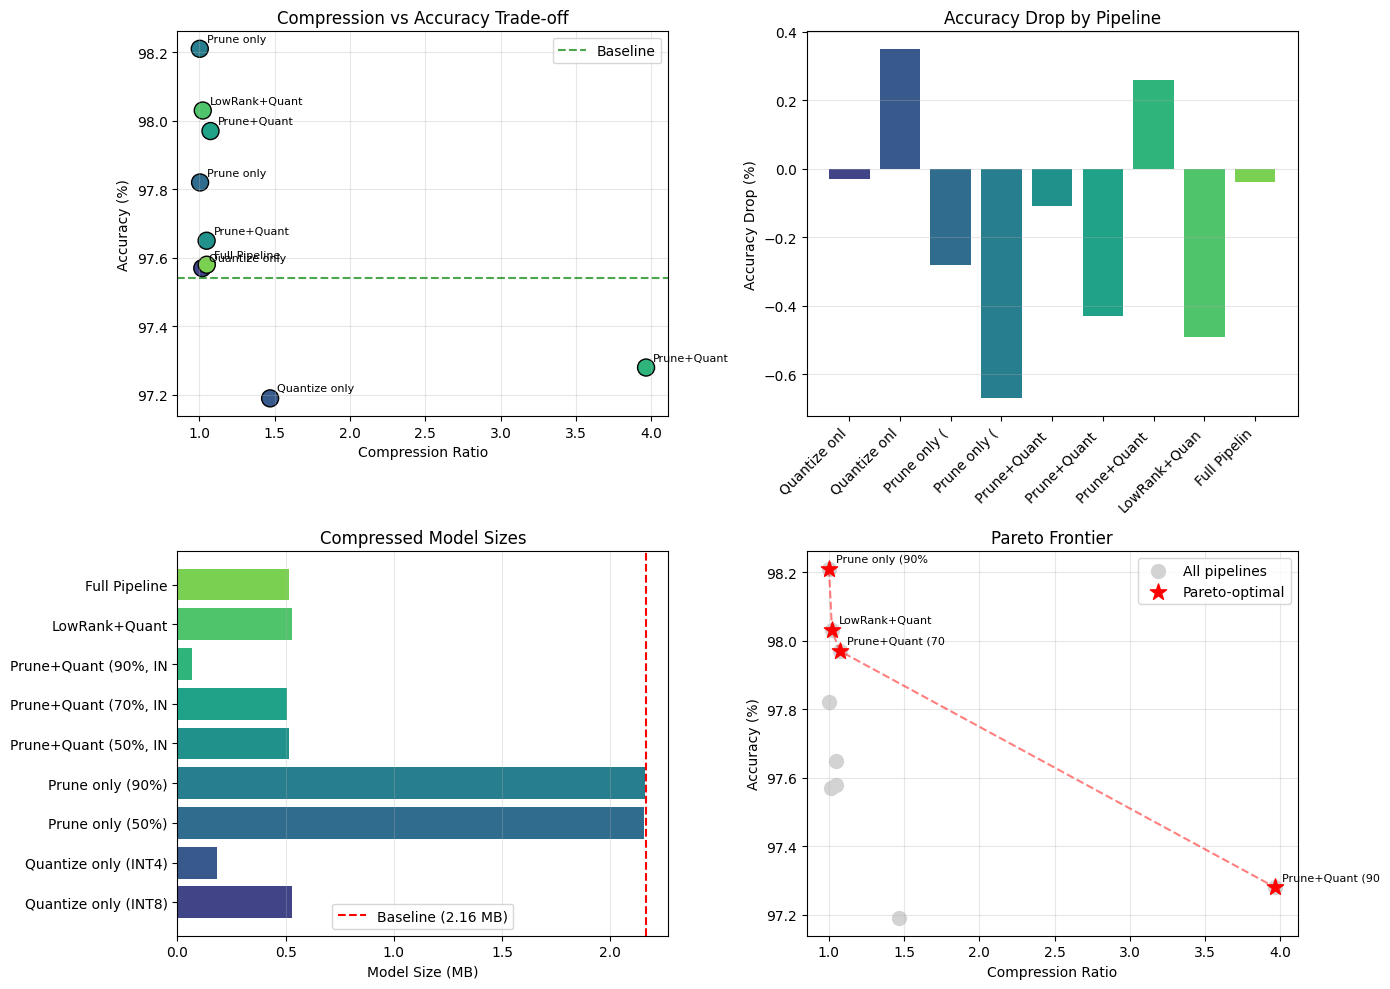


Pareto-optimal pipelines:
  Prune only (90%): 1.0× compression, 98.21% accuracy
  LowRank+Quant: 1.0× compression, 98.03% accuracy
  Prune+Quant (70%, INT8): 1.1× compression, 97.97% accuracy
  Prune+Quant (90%, INT4): 4.0× compression, 97.28% accuracy


In [16]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Compression vs Accuracy
ax = axes[0, 0]
names = list(results.keys())
compressions = [results[n].compression_ratio for n in names]
accuracies = [results[n].compressed_accuracy * 100 for n in names]

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(names)))
scatter = ax.scatter(compressions, accuracies, c=colors, s=150, edgecolors='black', linewidth=1)
ax.axhline(baseline_acc * 100, color='green', linestyle='--', alpha=0.7, label='Baseline')

for i, name in enumerate(names):
    short_name = name.split('(')[0].strip()[:15]
    ax.annotate(short_name, (compressions[i], accuracies[i]),
                textcoords="offset points", xytext=(5, 5), fontsize=8)

ax.set_xlabel('Compression Ratio')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Compression vs Accuracy Trade-off')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 2: Accuracy drop vs Compression
ax = axes[0, 1]
drops = [(results[n].original_accuracy - results[n].compressed_accuracy) * 100 for n in names]
ax.bar(range(len(names)), drops, color=colors)
ax.set_xticks(range(len(names)))
ax.set_xticklabels([n[:12] for n in names], rotation=45, ha='right')
ax.set_ylabel('Accuracy Drop (%)')
ax.set_title('Accuracy Drop by Pipeline')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Size comparison
ax = axes[1, 0]
sizes = [results[n].compressed_size_mb for n in names]
baseline_size = results['Quantize only (INT8)'].original_size_mb

ax.barh(range(len(names)), sizes, color=colors)
ax.axvline(baseline_size, color='red', linestyle='--', label=f'Baseline ({baseline_size:.2f} MB)')
ax.set_yticks(range(len(names)))
ax.set_yticklabels([n[:20] for n in names])
ax.set_xlabel('Model Size (MB)')
ax.set_title('Compressed Model Sizes')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# Plot 4: Pareto frontier
ax = axes[1, 1]

# Find Pareto-optimal points
points = list(zip(compressions, accuracies, names))
pareto = []
for i, (c, a, n) in enumerate(points):
    dominated = False
    for j, (c2, a2, _) in enumerate(points):
        if i != j and c2 >= c and a2 >= a and (c2 > c or a2 > a):
            dominated = True
            break
    if not dominated:
        pareto.append((c, a, n))

# Plot all points
ax.scatter(compressions, accuracies, c='lightgray', s=100, label='All pipelines')

# Highlight Pareto-optimal
pareto_c = [p[0] for p in pareto]
pareto_a = [p[1] for p in pareto]
ax.scatter(pareto_c, pareto_a, c='red', s=150, marker='*', label='Pareto-optimal', zorder=5)

# Connect Pareto points
pareto_sorted = sorted(pareto, key=lambda x: x[0])
ax.plot([p[0] for p in pareto_sorted], [p[1] for p in pareto_sorted], 'r--', alpha=0.5)

for c, a, n in pareto:
    ax.annotate(n[:15], (c, a), textcoords="offset points", xytext=(5, 5), fontsize=8)

ax.set_xlabel('Compression Ratio')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Pareto Frontier')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig('compression_pipeline_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPareto-optimal pipelines:")
for c, a, n in sorted(pareto, key=lambda x: x[0]):
    print(f"  {n}: {c:.1f}× compression, {a:.2f}% accuracy")

Production Considerations

In [17]:
class ProductionPipeline:
    """
    Production-ready compression pipeline with:
    - Automatic pipeline selection based on target
    - Validation throughout compression
    - Rollback on accuracy degradation
    """

    PRESETS = {
        'mobile': {
            'target_size_mb': 1.0,
            'max_accuracy_drop': 0.02,
            'steps': [
                ('prune', {'sparsity': 0.7}),
                ('finetune', {'epochs': 5}),
                ('quantize', {'bits': 8}),
            ]
        },
        'edge': {
            'target_size_mb': 0.5,
            'max_accuracy_drop': 0.05,
            'steps': [
                ('prune', {'sparsity': 0.9}),
                ('finetune', {'epochs': 5}),
                ('quantize', {'bits': 4}),
            ]
        },
        'server': {
            'target_size_mb': 5.0,
            'max_accuracy_drop': 0.01,
            'steps': [
                ('prune', {'sparsity': 0.3}),
                ('finetune', {'epochs': 3}),
                ('quantize', {'bits': 8}),
            ]
        },
        'maximum': {
            'target_size_mb': 0.1,
            'max_accuracy_drop': 0.10,
            'steps': [
                ('lowrank', {'rank_ratio': 0.3}),
                ('prune', {'sparsity': 0.9}),
                ('finetune', {'epochs': 10}),
                ('quantize', {'bits': 4}),
            ]
        }
    }

    def __init__(self, preset: str = 'mobile'):
        if preset not in self.PRESETS:
            raise ValueError(f"Unknown preset: {preset}. Available: {list(self.PRESETS.keys())}")
        self.config = self.PRESETS[preset]
        self.preset = preset

    def _create_step(self, step_type: str, params: dict) -> CompressionStep:
        if step_type == 'prune':
            return PruningStep(**params)
        elif step_type == 'quantize':
            return QuantizationStep(**params)
        elif step_type == 'lowrank':
            return LowRankStep(**params)
        elif step_type == 'finetune':
            return FinetuneStep(**params)
        else:
            raise ValueError(f"Unknown step type: {step_type}")

    def compress(self, model: nn.Module, train_loader: DataLoader,
                 test_loader: DataLoader, teacher: nn.Module = None) -> CompressionResult:
        """
        Run production compression with validation.
        """
        print(f"\n{'='*60}")
        print(f"PRODUCTION COMPRESSION: {self.preset.upper()}")
        print(f"Target: <{self.config['target_size_mb']} MB, <{100*self.config['max_accuracy_drop']:.1f}% accuracy drop")
        print(f"{'='*60}")

        steps = [self._create_step(t, p) for t, p in self.config['steps']]

        # If teacher provided, add distillation after pruning
        if teacher is not None:
            enhanced_steps = []
            for step in steps:
                enhanced_steps.append(step)
                if isinstance(step, PruningStep):
                    # Add distillation after pruning
                    enhanced_steps.append(
                        DistillationStep(teacher, temperature=4.0, alpha=0.3, epochs=3)
                    )
            steps = enhanced_steps

        pipeline = CompressionPipeline(steps)
        result = pipeline.run(model, train_loader, test_loader)

        # Validate against targets
        accuracy_drop = result.original_accuracy - result.compressed_accuracy

        print(f"\nValidation:")
        print(f"  Size: {result.compressed_size_mb:.2f} MB (target: <{self.config['target_size_mb']} MB) "
              f"{'✓' if result.compressed_size_mb <= self.config['target_size_mb'] else '✗'}")
        print(f"  Accuracy drop: {100*accuracy_drop:.2f}% (target: <{100*self.config['max_accuracy_drop']:.1f}%) "
              f"{'✓' if accuracy_drop <= self.config['max_accuracy_drop'] else '✗'}")

        return result

In [18]:
# Test production presets
print("\n" + "=" * 70)
print("PRODUCTION PRESET COMPARISON")
print("=" * 70)

preset_results = {}

for preset in ['server', 'mobile', 'edge', 'maximum']:
    model = TestMLP().to(device)
    model.load_state_dict(deepcopy(baseline_state))

    prod_pipeline = ProductionPipeline(preset)
    result = prod_pipeline.compress(model, train_loader, test_loader, teacher=teacher)
    preset_results[preset] = result


PRODUCTION PRESET COMPARISON

PRODUCTION COMPRESSION: SERVER
Target: <5.0 MB, <1.0% accuracy drop
Original: 567,434 params, 97.54% acc

Applying: Prune-Unstructured-30%
  → Accuracy: 97.59%

Applying: Distill-T4.0
  → Accuracy: 97.59%

Applying: Finetune-3ep
  → Accuracy: 97.83%

Applying: Quantize-8bit
  → Accuracy: 97.80%

Validation:
  Size: 0.52 MB (target: <5.0 MB) ✓
  Accuracy drop: -0.26% (target: <1.0%) ✓

PRODUCTION COMPRESSION: MOBILE
Target: <1.0 MB, <2.0% accuracy drop
Original: 567,434 params, 97.54% acc

Applying: Prune-Unstructured-70%
  → Accuracy: 97.17%

Applying: Distill-T4.0
  → Accuracy: 97.69%

Applying: Finetune-5ep
  → Accuracy: 97.96%

Applying: Quantize-8bit
  → Accuracy: 97.94%

Validation:
  Size: 0.52 MB (target: <1.0 MB) ✓
  Accuracy drop: -0.40% (target: <2.0%) ✓

PRODUCTION COMPRESSION: EDGE
Target: <0.5 MB, <5.0% accuracy drop
Original: 567,434 params, 97.54% acc

Applying: Prune-Unstructured-90%
  → Accuracy: 92.31%

Applying: Distill-T4.0
  → Accurac

In [19]:
# Final comparison
print("\n" + "=" * 90)
print("PRODUCTION PRESET SUMMARY")
print("=" * 90)
print(f"\n{'Preset':<15} {'Target Size':>12} {'Actual Size':>12} {'Compression':>12} {'Accuracy':>10} {'Drop':>8}")
print("-" * 75)

for preset, result in preset_results.items():
    target = ProductionPipeline.PRESETS[preset]['target_size_mb']
    drop = result.original_accuracy - result.compressed_accuracy
    print(f"{preset:<15} {target:>11.1f}MB {result.compressed_size_mb:>11.2f}MB {result.compression_ratio:>11.1f}× {100*result.compressed_accuracy:>9.2f}% {100*drop:>7.2f}%")


PRODUCTION PRESET SUMMARY

Preset           Target Size  Actual Size  Compression   Accuracy     Drop
---------------------------------------------------------------------------
server                  5.0MB        0.52MB         1.0×     97.80%   -0.26%
mobile                  1.0MB        0.52MB         1.0×     97.94%   -0.40%
edge                    0.5MB        0.08MB         3.2×     97.77%   -0.23%
maximum                 0.1MB        0.10MB         2.8×     96.82%    0.72%
